## Problem

** An interesting and popular urban science question is "Can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption for the city of NY can be found [here]( https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z).**

** The number of units can be found that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

## Acquiring the data

In [ ]:
__author__ = 'Solution by Linda Jaber, NYU CUSP 2018'
from __future__ import print_function

import sys
import os
import numpy as np

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib
    
import pandas as pd
import geopandas as gp

import matplotlib.pylab as plt
from matplotlib import gridspec
import pylab as pl
%pylab inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

In [ ]:
PUIdata = os.getenv('PUIDATA')
if PUIdata is None:
    os.environ['PUIDATA'] = '%s/PUIdata'%os.getenv('HOME')
    PUIdata = os.getnev('PUIDATA')
print('PUIdata: ', PUIdata)
    

In [ ]:
# downloading energy consumption dtata
url = 'https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD'
urllib.urlretrieve(url, 'Energy_and_Water_Data_Disclosure_for_Local_Law_84_2014__Data_for_Calendar_Year_2013_.csv')
%mkdir $PUIdata/local_law_84
!mv 'Energy_and_Water_Data_Disclosure_for_Local_Law_84_2014__Data_for_Calendar_Year_2013_.csv' $PUIdata/local_law_84
!ls $PUIdata/local_law_84

In [ ]:
# downloading MapPluto for Manhattan
url = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_18v1.zip'
urllib.urlretrieve(url, 'file.gz')
%mkdir $PUIdata/shapefiles
%mkdir $PUIdata/shapefiles/shapefile_MapPluto_Manhattan
!unzip file.gz -d $PUIdata/shapefiles/shapefile_MapPluto_Manhattan
!mv file.gz $PUIdata/shapefiles/shapefile_MapPluto_Manhattan
!ls $PUIdata/shapefiles/shapefile_MapPluto_Manhattan

In [5]:
# load the building size as a geoDF and the local law 84 as a dataframe
nrg = pd.read_csv(PUIdata + "/local_law_84/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2014__Data_for_Calendar_Year_2013_.csv")

bsize = gp.GeoDataFrame.from_file(PUIdata + "/shapefiles/shapefile_MapPluto_Manhattan/MNMapPLUTO.shp")

In [6]:
nrg.head()

,Record Number,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Postcode,DOF Benchmarking Submission Status,...,DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA
0,12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,...,NaN,Office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,...,82730.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,...,440360.0,NaN,1.0,40.749652,-74.006471,4.0,3.0,99.0,1012266.0,Hudson Yards-Chelsea-Flatiron-Union Square ...
4,15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
bsize.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,MAPPLUTO_F,SHAPE_area,SHAPE_len,geometry
0,MN,1545,52,108,138,4000,02,5,10028,E022,...,0.000000e+00,None,1,None,None,18V1,0,2867.154705,260.428942,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,MN,723,7501,104,93,6000,02,3,10001,E003,...,1.007230e+09,11/30/2006,1,None,None,18V1,7,10907.639931,417.764545,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,MN,1680,48,111,170,5000,04,8,10029,E091,...,0.000000e+00,None,1,1,1,18V1,0,2665.033424,256.893308,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,MN,1385,32,108,130,2003,02,4,10021,E039,...,0.000000e+00,None,1,None,None,18V1,0,15302.920914,505.033271,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,MN,1197,27,107,169,5000,03,6,10024,E074,...,0.000000e+00,None,1,None,None,18V1,0,4374.612456,295.652483,"POLYGON ((992273.6849975586 224863.4904174805,..."


## Exploring the data 

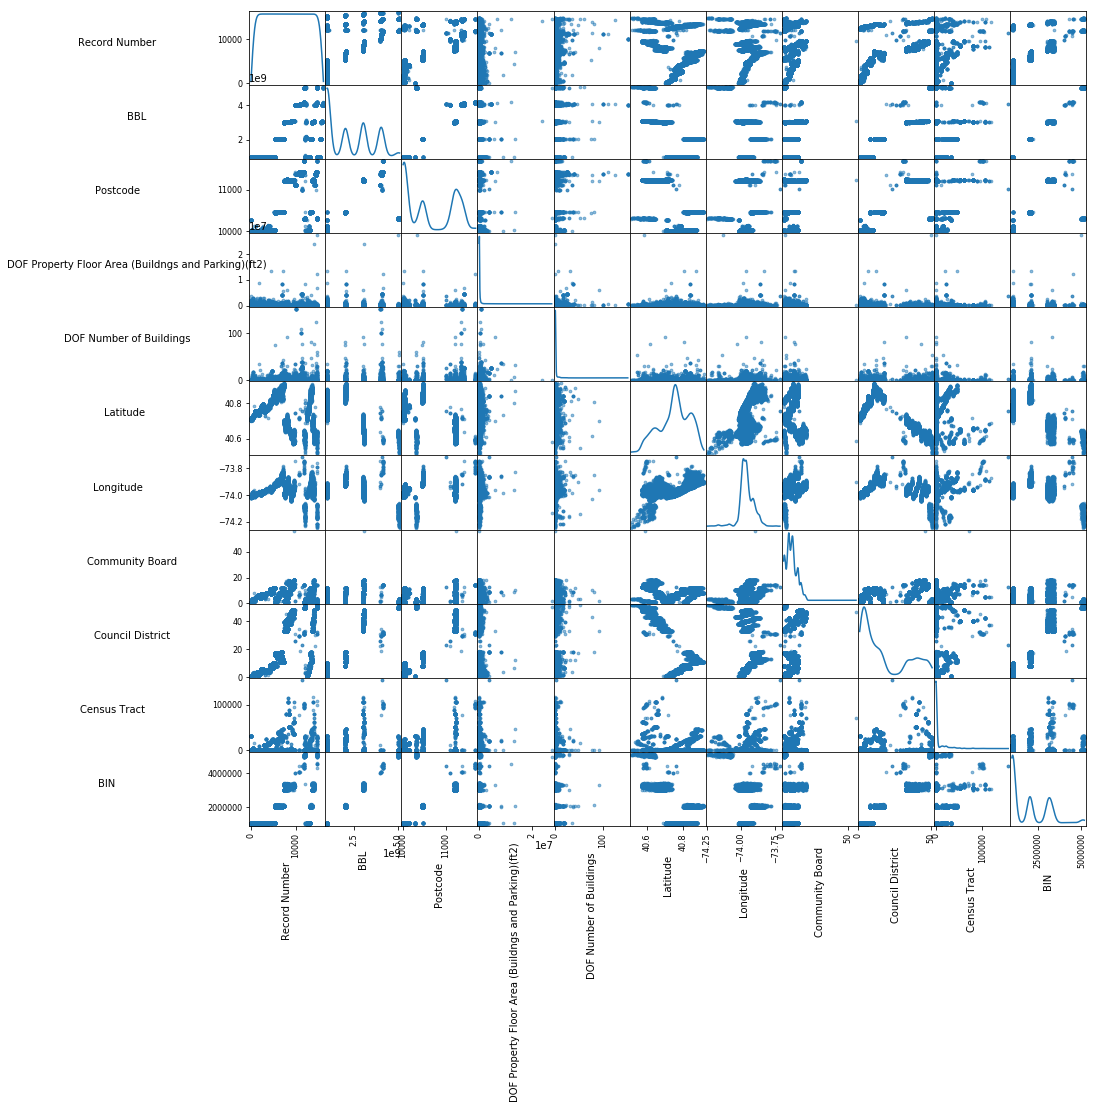

In [8]:
# scatter matrix
sfig = pd.scatter_matrix(nrg, s=30, figsize=(15, 15), diagonal='kde')
n = len(sfig)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = sfig[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 100

#### Figure 1: This is a scatter matrix performed on all the variables in the energy consuption data. There are 32 variables. However only 11 got plotted. That is because the rest of the columns had entries pandas couldn't read. None of the plotted values are the ones we are interested in nor any of them show a linear relation. Please note that plots on the diagonal line represent the variable plotted againt its self, here plotted as a smoothed histogram.

## Cleaning and Aggregation 

In [9]:
nrg.columns

Index(['Record Number', 'BBL', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],
      dtype='object')

In [10]:
# dropping unnecessary columns from the energy consumption data
nrg.drop(['Record Number', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'], axis=1, inplace=True)

In [11]:
bsize.columns.sort_values()

Index(['APPBBL', 'APPDate', 'Address', 'AreaSource', 'AssessLand', 'AssessTot',
       'BBL', 'BldgArea', 'BldgClass', 'BldgDepth', 'BldgFront', 'Block',
       'BoroCode', 'Borough', 'BsmtCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010',
       'ComArea', 'CommFAR', 'CondoNo', 'Council', 'EDesigNum', 'Easements',
       'ExemptLand', 'ExemptTot', 'Ext', 'FIRM07_FLA', 'FacilFAR',
       'FactryArea', 'FireComp', 'GarageArea', 'HealthArea', 'HealthCent',
       'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot', 'LotArea',
       'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PFIRM15_FL', 'PLUTOMapID',
       'PolicePrct', 'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea',
       'SHAPE_area', 'SHAPE_len', 'SPDist1', 'SPDist2', 'SPDist3', 'Sanborn',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'SchoolDist', 'SplitZone',
       'StrgeArea', 'TaxMap', 'Tract201

In [12]:
# dropping unnecessary columns from the pluto data
bsize.drop(['APPBBL', 'APPDate', 'Address', 'AreaSource', 'AssessLand', 'AssessTot',
       'BldgArea', 'BldgClass', 'BldgDepth', 'BldgFront', 'Block',
       'BoroCode', 'Borough', 'BsmtCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010',
       'ComArea', 'CommFAR', 'CondoNo', 'Council', 'EDesigNum', 'Easements',
       'ExemptLand', 'ExemptTot', 'Ext', 'FIRM07_FLA', 'FacilFAR',
       'FactryArea', 'FireComp', 'GarageArea', 'HealthArea', 'HealthCent',
       'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot', 'LotArea',
       'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PFIRM15_FL', 'PLUTOMapID',
       'PolicePrct', 'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea',
       'SHAPE_area', 'SHAPE_len', 'SPDist1', 'SPDist2', 'SPDist3', 'Sanborn',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'SchoolDist', 'SplitZone',
       'StrgeArea', 'TaxMap', 'Tract2010', 'Version',
       'XCoord', 'YCoord', 'YearAlter1', 'YearAlter2', 'ZMCode',
       'ZipCode', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'ZoneMap'], axis=1, inplace=True)

In [13]:
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000


In [14]:
bsize.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry
0,16,18,1920,1.015450e+09,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,10,10,1910,1.016800e+09,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,26,26,1900,1.011970e+09,"POLYGON ((992273.6849975586 224863.4904174805,..."


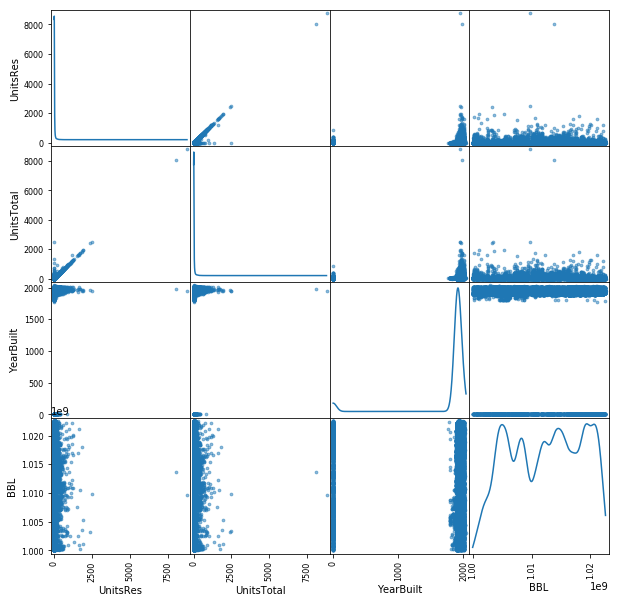

In [15]:
sfig = pd.scatter_matrix(bsize, s=30, figsize=(10, 10), diagonal='kde')

#### Figure 2: This is a scatter matrix of the variables in the reduced Pluto data (i.e after dropping columns that we do not need for our analysis). Each variable is plotted against every other variable. Plots of the variable against itself are represented along the diagonal of the plot. One linear relation is seen between the number of total units and the number of residential units in a buidling. However this relation is insignificant as the two variables are dependent on each other. We plot this to make sure pandas is able to read all the data in the columns, so now we can move to calculations.

In [16]:
# converting 'Site EUI(kBtu/ft2)' column in the energy consumption dataframe to numeric values for pandas to be able to read it
# the column includes non-numeric values other than Nan's so pandas will not plot it
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors='coerce')

# converting 'Reported Property Floor Area (Building(s)) (ft²)' column in the energy consumption dataframe for pandas to be able to read it
# the column includes non-numeric values other than Nan's so pandas will not plot it
nrg['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(nrg['Reported Property Floor Area (Building(s)) (ft²)'], errors='coerce')

In [17]:
# checking conversion worked
nrg['Site EUI(kBtu/ft2)'].astype(float)[:10], nrg['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)[:10]

(0   NaN
 1   NaN
 2   NaN
 3   NaN
 4   NaN
 5   NaN
 6   NaN
 7   NaN
 8   NaN
 9   NaN
 Name: Site EUI(kBtu/ft2), dtype: float64, 0    918919.0
 1         NaN
 2     64200.0
 3         NaN
 4     50000.0
 5     61800.0
 6    102198.0
 7     46620.0
 8         NaN
 9     54029.0
 Name: Reported Property Floor Area (Building(s)) (ft²), dtype: float64)

In [18]:
# checking conversion worked
print ("number of missing energy observations:", np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum())

number of missing energy observations: 4623


In [19]:
# checking conversion worked
print ("fraction of missing energy observations: %.2f"%(np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum() /
      len(nrg['Site EUI(kBtu/ft2)'])))

fraction of missing energy observations: 0.29


In [20]:
# double checking if all the columns in the pluto data are readable by pandas
bsize.UnitsRes.astype(float)[:5], bsize.UnitsTotal.astype(float)[:5], bsize.YearBuilt.astype(float)[:5], bsize.BBL.astype(float)[:5]

(0    16.0
 1    50.0
 2    10.0
 3    29.0
 4    26.0
 Name: UnitsRes, dtype: float64, 0    18.0
 1    50.0
 2    10.0
 3    32.0
 4    26.0
 Name: UnitsTotal, dtype: float64, 0    1920.0
 1    1914.0
 2    1910.0
 3    1928.0
 4    1900.0
 Name: YearBuilt, dtype: float64, 0    1.015450e+09
 1    1.007238e+09
 2    1.016800e+09
 3    1.013850e+09
 4    1.011970e+09
 Name: BBL, dtype: float64)

## Merging the two datasets

In [21]:
# merging in a geodataframe for mapping, and in a regular DF for analysis (more portable)
bblnrgdataGPD = bsize.merge(nrg, on='BBL')
bblnrgdata = nrg.merge(bsize, on='BBL')
bblnrgdata.drop('geometry', axis=1, inplace=True)

In [22]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt
0,1.006700e+09,NaN,NaN,0,1,1987
1,1.004370e+09,NaN,NaN,0,4,1920
2,1.013110e+09,125.4,330000.0,0,56,1977
3,1.009220e+09,NaN,NaN,148,148,1963
4,1.007400e+09,NaN,68329.0,0,1,1920


In [23]:
type(bblnrgdata)

pandas.core.frame.DataFrame

In [24]:
bblnrgdataGPD.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,...",68.7,95844.0
1,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,...",87.4,206989.0
2,72,72,1923,1.021740e+09,"POLYGON ((1004080.155029297 252930.9956054688,...",140.4,52920.0
3,107,108,1931,1.008830e+09,"POLYGON ((989337.639831543 209686.7838134766, ...",96.5,98359.0
4,134,138,1910,1.008570e+09,"POLYGON ((988035.3540039062 210290.9854125977,...",36.4,154000.0


In [25]:
type(bblnrgdataGPD)

geopandas.geodataframe.GeoDataFrame

## Plotting the data as a choropleth for the two quantities of interest: number of units and energy consumed energy

In [26]:
# we want to use log transformation so we will have a look at the data to see if there is any zeros
# The real logarithmic function logb(x) is defined only for x>0. Log 0 is undefined
(bblnrgdataGPD['Reported Property Floor Area (Building(s)) (ft²)']).describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    5.545000e+03
mean     2.133406e+05
std      3.242996e+05
min      0.000000e+00
25%               NaN
50%               NaN
75%               NaN
max      9.515627e+06
Name: Reported Property Floor Area (Building(s)) (ft²), dtype: float64

In [27]:
(bblnrgdataGPD['Site EUI(kBtu/ft2)']).describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    5.047000e+03
mean     1.155594e+03
std      4.284263e+04
min      0.000000e+00
25%               NaN
50%               NaN
75%               NaN
max      3.018493e+06
Name: Site EUI(kBtu/ft2), dtype: float64

In [28]:
# we notice zeros in the data
# one of the ways to deal with this is to Add a constant value to each value of the variables then take a log transformation
bblnrgdataGPD['logarea'] = np.log10(bblnrgdataGPD['Reported Property Floor Area (Building(s)) (ft²)']+30)
bblnrgdataGPD['lognrg'] = np.log10(bblnrgdataGPD['Site EUI(kBtu/ft2)']+30)

Text(0.5,1,'The Site Energy Use Intensity or EUI (kBtu/sqft)')

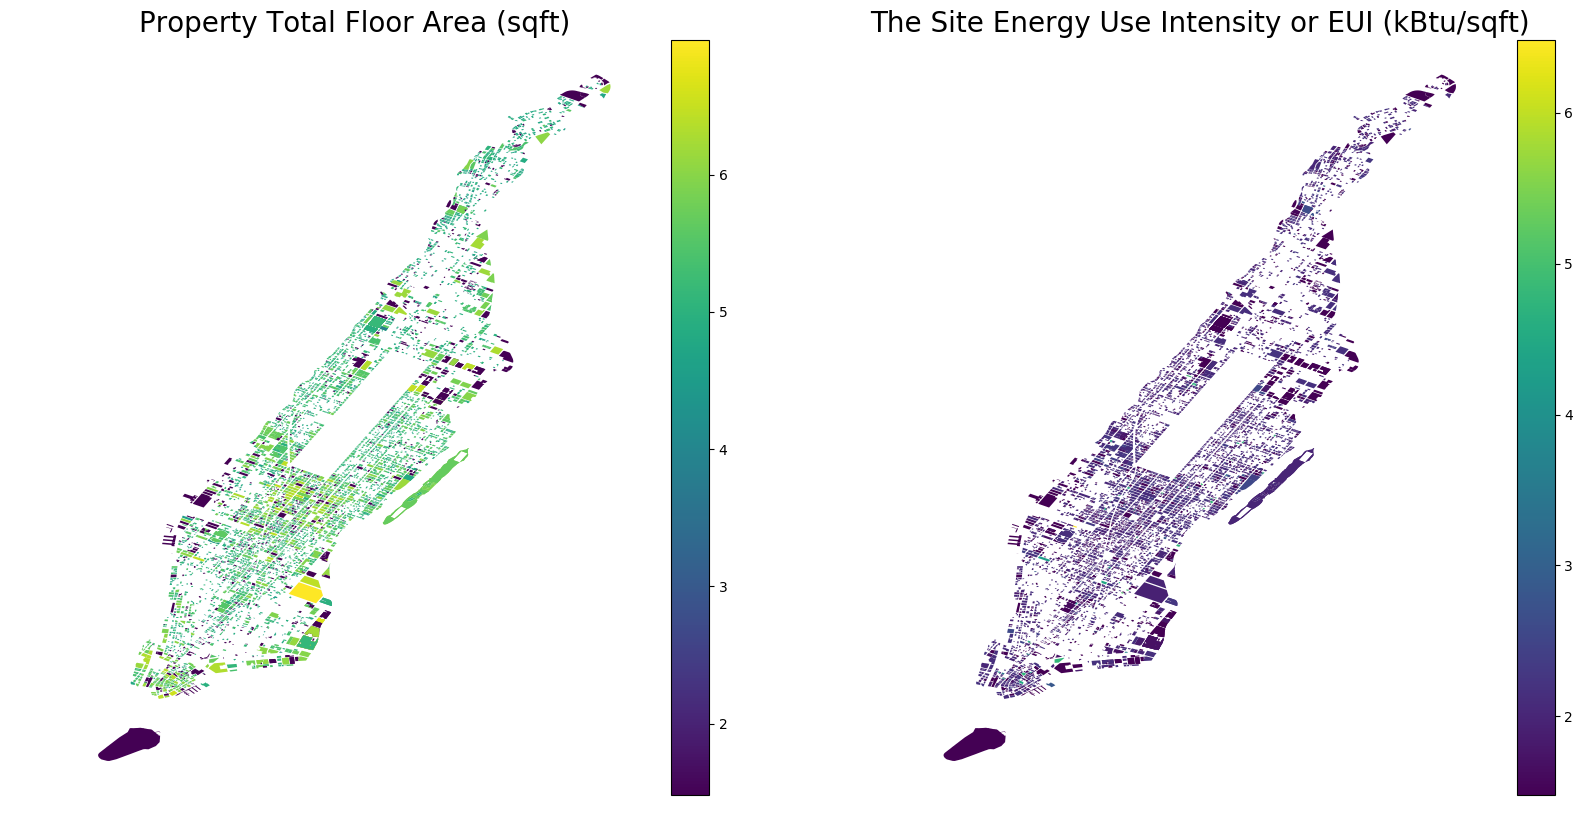

In [29]:
# plotting

fig = plt.figure(figsize=(20,10), dpi=100)
ax1 = fig.add_subplot(121)

bblnrgdataGPD.plot(column='logarea', ax=ax1, legend=True)
ax1.axis('off')
ax1.set_title('Property Total Floor Area (sqft)', fontsize=20)

ax2 = fig.add_subplot(122)
bblnrgdataGPD.plot(column='lognrg', ax=ax2, legend=True)
ax2.axis('off')
ax2.set_title('The Site Energy Use Intensity or EUI (kBtu/sqft)', fontsize=20)


#### Figure 3: The figure above is a plot of the self-reported total gross square footage (ft2) of properties (Left), and the the Energy Use Intensity (EUI), as calculated by Portfolio Manager, at the property site (Right) in Manhattan, NYC.  EUI equals the amount of energy consumed at the site in thousand British thermal units (kBtus) per gross square foot (kBtu/ft2) of the property. Site EUI values are the result of self-reported entries. The data is from the benchmarked calendar year 2013 reported by August 2014 under local law 84. Note that the plots use a logarithmic scale (log10). We notice some outliers in the map of floor area. One big yellow zone appears in lower east side of Manhattan. This is an indicator of a very large building or most probably a group of buildings on the same tax lot. From the location it looks like it is Stuyvesant Town–Peter Cooper Village; a large, post-World War II private residential development. The map of of energy consumption is mostly homogenous.

## Feature Engineering
The question was not if larger buildings consume more energy, its if occupancy increases consumption, so we want to model *total energy* with *total units*.

minimum building energy value 0.0
maximum building energy value 350145188000.0


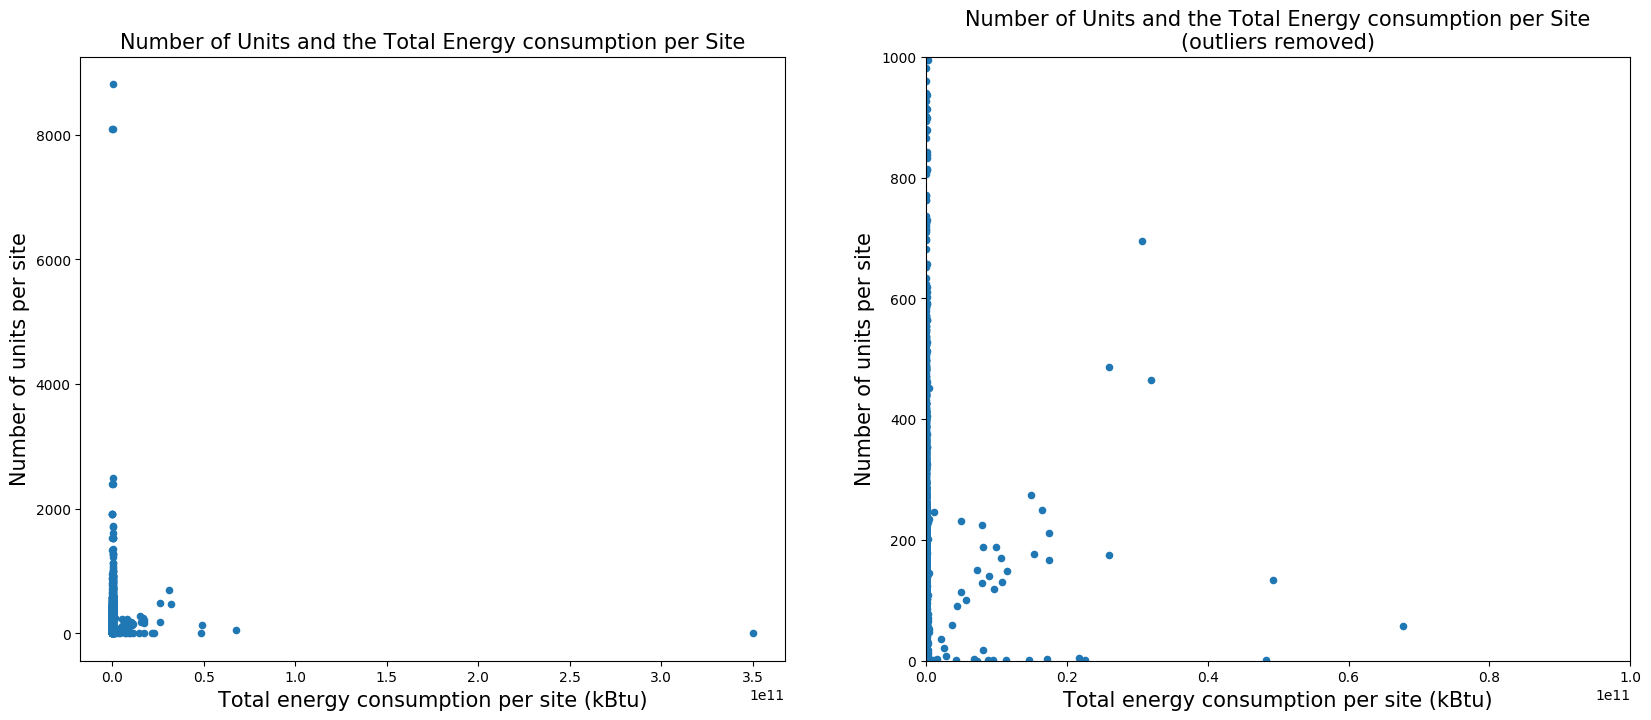

In [30]:
## multiplying area by energy/area to get total energy per building
bblnrgdata['nrg'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'].astype(float) *\
                bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)

# plotting the two variables (total energy consumption and number of units) against each other
fig, ax = plt.subplots(1, 2, figsize=(20,8), dpi=100)
bblnrgdata.plot('nrg', 'UnitsTotal', kind='scatter', marker='o', ax=ax[0])
ax[0].set_xlabel('Total energy consumption per site (kBtu)', fontsize=15)
ax[0].set_ylabel('Number of units per site', fontsize=15)
ax[0].set_title('Number of Units and the Total Energy consumption per Site', fontsize=15)

# after plotting the above variables we notice that most of the data is clustered between 0 and 1e11 (on the x-axis)
# and 0 and 2000 (on the y-axis). to better view the data points we mask the outliers by limiting the axes
bblnrgdata.plot('nrg', 'UnitsTotal', kind='scatter', marker='o', ax=ax[1], xlim=(0,1e11), ylim=(0,1000),)
ax[1].set_xlabel('Total energy consumption per site (kBtu)', fontsize=15)
ax[1].set_ylabel('Number of units per site', fontsize=15)
ax[1].set_title('Number of Units and the Total Energy consumption per Site\n(outliers removed)', fontsize=15)

print('minimum building energy value {}'.format(bblnrgdata.nrg.min()))
print('maximum building energy value {}'.format(bblnrgdata.nrg.max()))

### Figure 4: This is scatter plot of the total number of units in a benchmarked site plotted against the total energy consumption in the site. The plot to the left shows all the data from the benchmarked calendar year 2013 reported by August 2014 under local law 84. We notices some outliers. The second plot to the right shows the same data plotted after masking outliers. Thre can be seen a positive relation between the two variables in question yet it is till hard to visualize. Here using a logarithmic scale would enhance the plot.

In [31]:
## cutting the data to get a better model
## limiting the units between 10 and 1000 rather than 1 and 1000 ended up rendering a better scatter plot
limited_bblnrgdata = bblnrgdata[(bblnrgdata['UnitsTotal'] > 10) & (bblnrgdata['UnitsTotal'] < 1000)\
& (bblnrgdata['nrg'] > 1000) & (bblnrgdata['nrg'] < 1e10)]
limited_bblnrgdata.reset_index(drop=True, inplace=True)
limited_bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,nrg
0,1.013110e+09,125.4,330000.0,0,56,1977,41382000.0
1,1.008150e+09,117.0,364000.0,0,64,1954,42588000.0
2,1.005050e+09,82.1,235370.0,0,24,1926,19323877.0
3,1.021420e+09,137.7,64806.0,54,62,1924,8923786.2
4,1.021750e+09,103.2,62839.0,75,85,1920,6484984.8


In [32]:
# checking the new data limits
print('minimum building energy value {}'.format(limited_bblnrgdata.nrg.min()))
print('maximum building energy value {}'.format(limited_bblnrgdata.nrg.max()))
print('minimum number of units value {}'.format(limited_bblnrgdata.UnitsTotal.min()))
print('maximum number of units value {}'.format(limited_bblnrgdata.UnitsTotal.max()))

minimum building energy value 5344.0
maximum building energy value 9926784000.0
minimum number of units value 11
maximum number of units value 995


Text(0.5,1,'Figure 6: Number of Units as a function of the\nTotal Energy consumption per Site (outliers removed)')

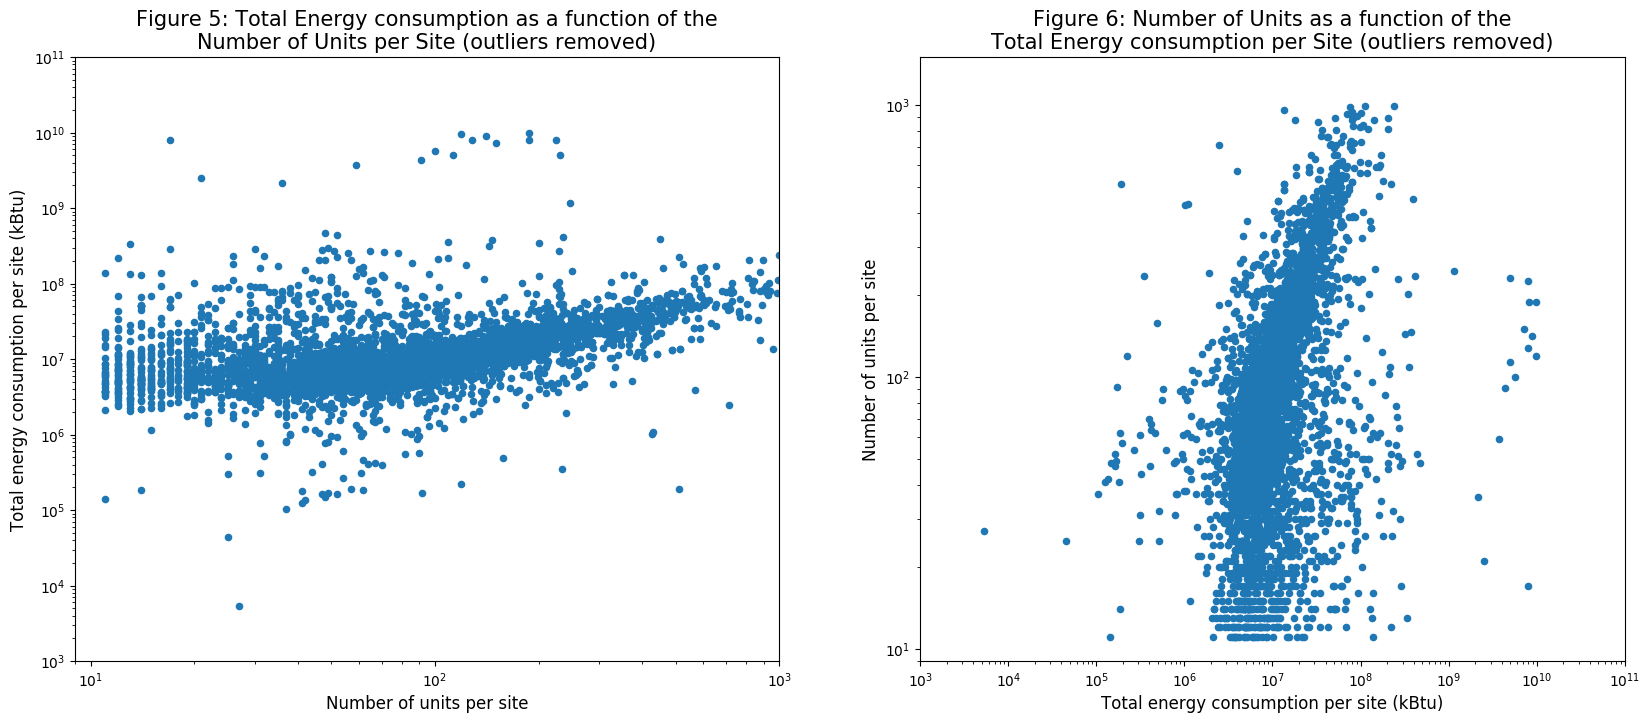

In [33]:
# plotting using a logarithic scale loglog=True

fig, ax = plt.subplots(1, 2, figsize=(20,8), dpi=100)

limited_bblnrgdata.plot('UnitsTotal', 'nrg', kind='scatter', marker='o', ax=ax[0], xlim=(9,1000), ylim=(1000,1e11), loglog=True)
ax[0].set_ylabel('Total energy consumption per site (kBtu)', fontsize=12)
ax[0].set_xlabel('Number of units per site', fontsize=12)
ax[0].set_title('Figure 5: Total Energy consumption as a function of the\nNumber of Units per Site (outliers removed)', fontsize=15)

limited_bblnrgdata.plot('nrg', 'UnitsTotal', kind='scatter', marker='o', ax=ax[1], xlim=(1000,1e11), ylim=(9,1500), loglog=True)
ax[1].set_xlabel('Total energy consumption per site (kBtu)', fontsize=12)
ax[1].set_ylabel('Number of units per site', fontsize=12)
ax[1].set_title('Figure 6: Number of Units as a function of the\nTotal Energy consumption per Site (outliers removed)', fontsize=15)

#### Figure 5 (Left): This is a scatter plot of the total energy consumption for benshmarked sites as a function of each site's number of units in 2013. Outliers have been removed and a logarithmic scale is used to better visualize the data points. A positive relation between both variables can be visualized. There is a concentration of datapoints showing an increase in the energy consumed as the number of units in a site increases. 

#### Figure 6 (Right): This is a scatter plot of the number of units in a benshmarked site as a function of the total energy consumed by the site in 2013. Outliers have been removed and a logarithmic scale is used to better visualize the data points. The plot does not show a linear relation. A concentration of sites with different number of units fall within a limited range of energy consumption. This shows that there is no significant effect on the number of units as the energy consumption increase. It makes more sense to use the first plot with the Numebr of Units as an independent variable.

## Modeling NRG as a linear function of the number of units in the building 

In [34]:
# creating columns of the data in logarithmic scale
limited_bblnrgdata['lognrg'] = np.log10(limited_bblnrgdata['nrg'])
limited_bblnrgdata['logunits'] = np.log10(limited_bblnrgdata['UnitsTotal'])

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [35]:
limited_bblnrgdata.head(2)

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,nrg,lognrg,logunits
0,1.013110e+09,125.4,330000.0,0,56,1977,41382000.0,7.616811,1.748188
1,1.008150e+09,117.0,364000.0,0,64,1954,42588000.0,7.629287,1.806180


### Units vs Energy

In [36]:
# OLS

ols_model_fit_1 = ols(formula='logunits ~ lognrg', data=limited_bblnrgdata).fit()
ols_model_fit_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logunits   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     897.3
Date:                Mon, 25 Feb 2019   Prob (F-statistic):          4.89e-179
Time:                        18:27:56   Log-Likelihood:                -1626.8
No. Observations:                4253   AIC:                             3258.
Df Residuals:                    4251   BIC:                             3270.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.6888      0.086     -7.987      0.000        -0.858    -0.520
lognrg         0.3669      0.012     29.954      0.000         0.343     0.391
==============================================================================
Omnibus:                      139.777   Durbin-Watson:                   1.380
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.952
Skew:                          -0.445   Prob(JB):                     3.71e-34
Kurtosis:                       3.278   Cond. No.                         114.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Energy against Units

In [37]:
# OLS

ols_model_fit_2= ols(formula='lognrg ~ logunits', data=limited_bblnrgdata).fit()
ols_model_fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lognrg   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     897.3
Date:                Mon, 25 Feb 2019   Prob (F-statistic):          4.89e-179
Time:                        18:27:56   Log-Likelihood:                -2175.8
No. Observations:                4253   AIC:                             4356.
Df Residuals:                    4251   BIC:                             4368.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.1285      0.031    200.344      0.000         6.069     6.189
logunits       0.4750      0.016     29.954      0.000         0.444     0.506
==============================================================================
Omnibus:                     1439.666   Durbin-Watson:                   1.604
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20550.386
Skew:                           1.213   Prob(JB):                         0.00
Kurtosis:                      13.492   Cond. No.                         12.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

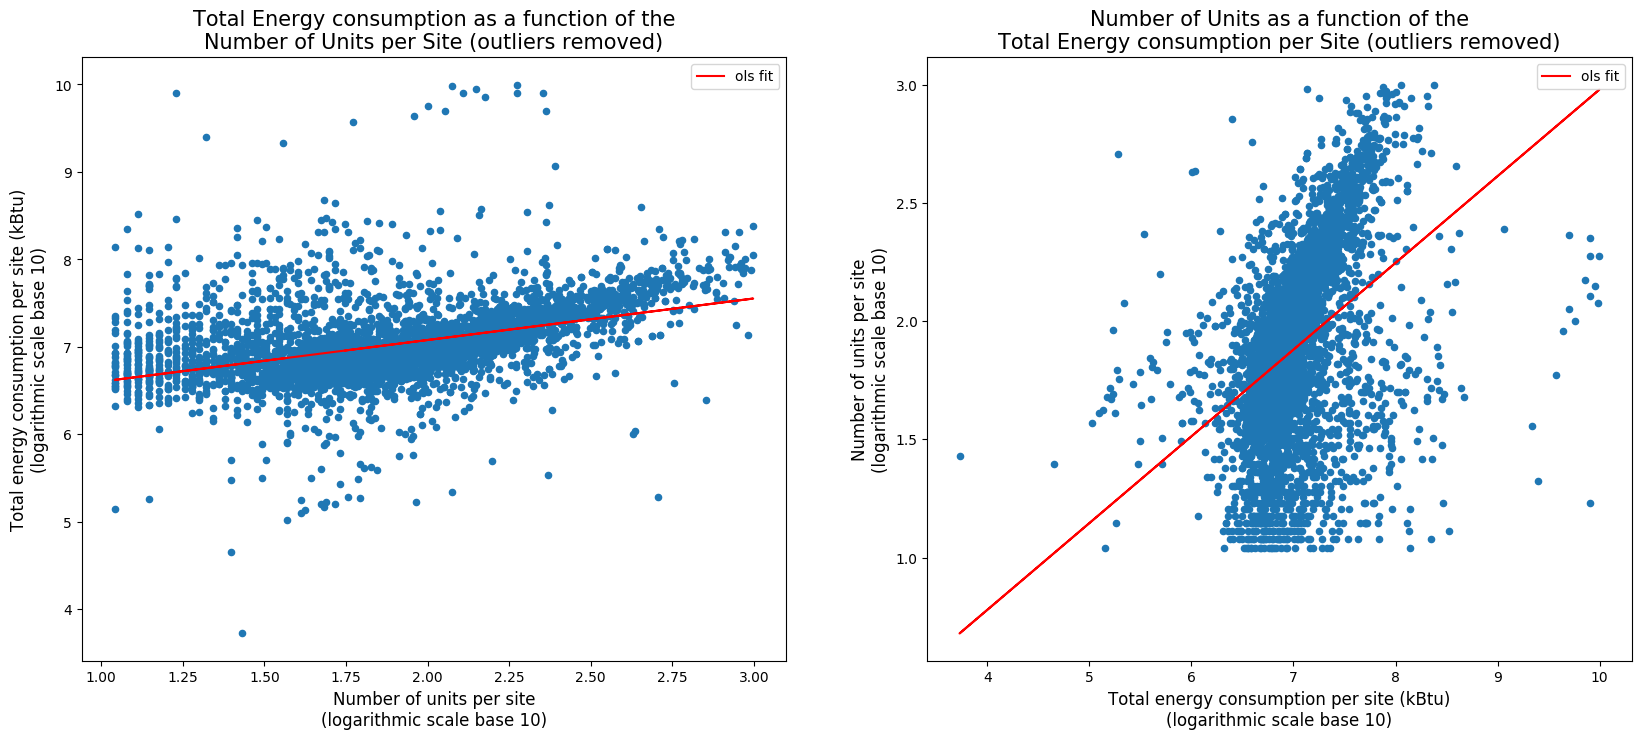

In [38]:
# plotting
fig, ax = plt.subplots(1, 2, figsize=(20,8), dpi=100)

# energy versus units
limited_bblnrgdata.plot('logunits', 'lognrg', kind='scatter', marker='o', ax=ax[0])
ax[0].plot(limited_bblnrgdata['logunits'], ols_model_fit_2.predict(limited_bblnrgdata), 'r', label='ols fit' )
ax[0].set_ylabel('Total energy consumption per site (kBtu)\n(logarithmic scale base 10)', fontsize=12)
ax[0].set_xlabel('Number of units per site\n(logarithmic scale base 10)', fontsize=12)
ax[0].set_title('Total Energy consumption as a function of the\nNumber of Units per Site (outliers removed)', fontsize=15)
ax[0].legend()

#units versus energy
limited_bblnrgdata.plot('lognrg', 'logunits', kind='scatter', marker='o', ax=ax[1])
ax[1].plot(limited_bblnrgdata['lognrg'], ols_model_fit_1.predict(limited_bblnrgdata), 'r', label='ols fit')
ax[1].set_xlabel('Total energy consumption per site (kBtu)\n(logarithmic scale base 10)', fontsize=12)
ax[1].set_ylabel('Number of units per site\n(logarithmic scale base 10)', fontsize=12)
ax[1].set_title('Number of Units as a function of the\nTotal Energy consumption per Site (outliers removed)', fontsize=15)
ax[1].legend()

#### Figure 7: The two plots in figure 5 and 6 are generated again, however now shown with their respective model fit using ordinary least squares in statsmodels package. Looking at the summary of both models the values of r-squared are the same, since the two plots are fitting the same data with a linear model. One is minimizing the vertical distances while the other is minizmizing the horizontal distances. However, the value of r-squared is small which means that the models' ability to predict the linear variation in the data is low. On the other hand, the log likelihood value of energy vs units (left) is different from that of units vs energy (right). We would need to compare it with the log likelihood of a different model (a more complex one). The model with higher values would better produce our data. Visually the plot to the left makes more sense which justifies my answer above to use the Number of Units as independent variable.

## Second degree polynomial fit

### Units versus Energy

In [39]:
# sorting values
limited_bblnrgdata.sort_values(by='lognrg', inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [40]:
# OLS
limited_bblnrgdata['lognrg2'] = limited_bblnrgdata['lognrg'] ** 2
ols_model_fit_3 = ols(formula='logunits ~ lognrg2 + lognrg', data=limited_bblnrgdata).fit()
ols_model_fit_3.summary()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logunits   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     470.5
Date:                Mon, 25 Feb 2019   Prob (F-statistic):          2.64e-185
Time:                        18:27:57   Log-Likelihood:                -1608.8
No. Observations:                4253   AIC:                             3224.
Df Residuals:                    4250   BIC:                             3243.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -3.6728      0.503     -7.304      0.000        -4.659    -2.687
lognrg2       -0.0575      0.010     -6.023      0.000        -0.076    -0.039
lognrg         1.1970      0.138      8.651      0.000         0.926     1.468
==============================================================================
Omnibus:                       90.150   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.757
Skew:                          -0.344   Prob(JB):                     9.76e-22
Kurtosis:                       3.267   Cond. No.                     4.86e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

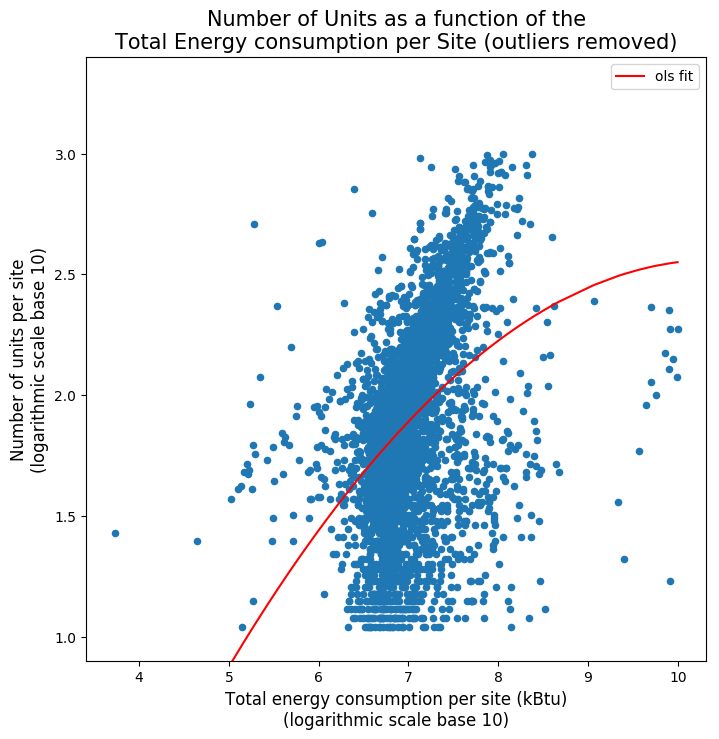

In [41]:
#units versus energy
fig, ax = plt.subplots(figsize=(8,8), dpi=100)

limited_bblnrgdata.plot('lognrg', 'logunits', kind='scatter', marker='o', ylim=(0.9,3.4), ax=ax)
ax.plot(limited_bblnrgdata['lognrg'], ols_model_fit_3.predict(limited_bblnrgdata), 'r', label='ols fit')
ax.set_xlabel('Total energy consumption per site (kBtu)\n(logarithmic scale base 10)', fontsize=12)
ax.set_ylabel('Number of units per site\n(logarithmic scale base 10)', fontsize=12)
ax.set_title('Number of Units as a function of the\nTotal Energy consumption per Site (outliers removed)', fontsize=15)
ax.legend()

#### Figure 8-a: This a scatter plot of the total number of units versus the total energy consumption in a benchmarked site in the site in 2013. The data is fitted with a second degree model. this model shows almost the same values of r-squared and log likelihood. Even a more complex model couldn't refelct a stronger linear relation between the variables. Again using the units as independent variables makes more sense.

### Energy versus Units

In [42]:
# sorting values
limited_bblnrgdata.sort_values(by='logunits', inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [43]:
# OLS
limited_bblnrgdata['logunits2'] = limited_bblnrgdata['logunits']**2
ols_model_fit_4= ols(formula='lognrg ~ logunits2 + logunits', data=limited_bblnrgdata).fit()
ols_model_fit_4.summary()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lognrg   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     642.5
Date:                Mon, 25 Feb 2019   Prob (F-statistic):          1.61e-244
Time:                        18:27:57   Log-Likelihood:                -2021.3
No. Observations:                4253   AIC:                             4049.
Df Residuals:                    4250   BIC:                             4068.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      7.9825      0.108     74.112      0.000         7.771     8.194
logunits2      0.5274      0.029     17.897      0.000         0.470     0.585
logunits      -1.5452      0.114    -13.565      0.000        -1.768    -1.322
==============================================================================
Omnibus:                     1571.169   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29280.467
Skew:                           1.282   Prob(JB):                         0.00
Kurtosis:                      15.596   Cond. No.                         121.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

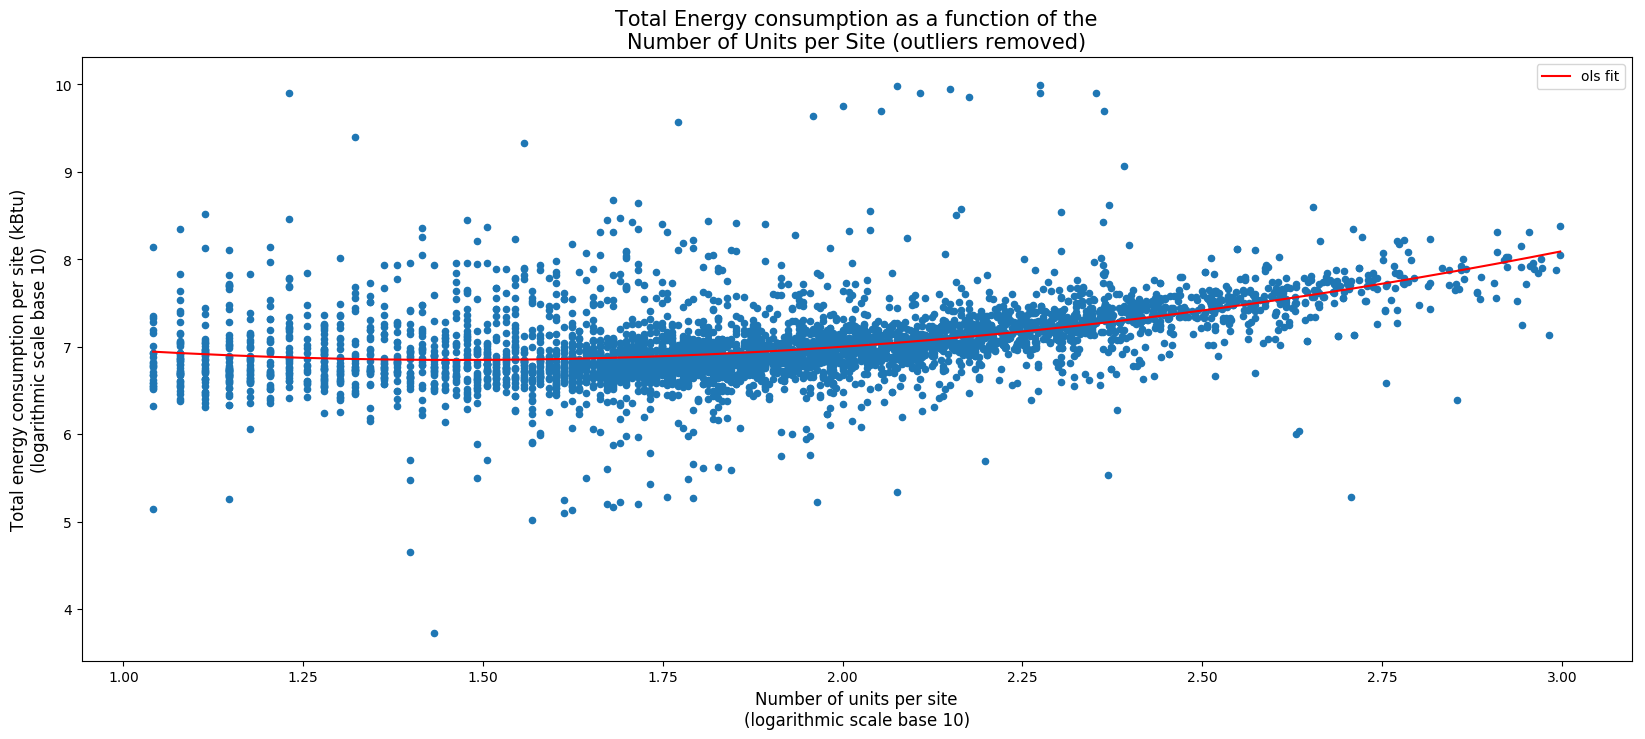

In [44]:
fig, ax = plt.subplots(figsize=(20,8), dpi=100)

limited_bblnrgdata.plot('logunits', 'lognrg', kind='scatter', marker='o', ax=ax)
ax.plot(limited_bblnrgdata['logunits'], ols_model_fit_4.predict(limited_bblnrgdata), 'r', label='ols fit')
ax.set_ylabel('Total energy consumption per site (kBtu)\n(logarithmic scale base 10)', fontsize=12)
ax.set_xlabel('Number of units per site\n(logarithmic scale base 10)', fontsize=12)
ax.set_title('Total Energy consumption as a function of the\nNumber of Units per Site (outliers removed)', fontsize=15)
ax.legend()

#### Figure 8-b: This a scatter plot of the total energy consumption in a benchmarked site versus the total number of units in the site in 2013. The data is fitted with a second degree model. this model shows higher values of r-squared and log likelihood. It seems to predict the data better than the linear model. However we need to make sure that we are not overfitting our data by using a complex model.

## Calculating the chi square and likelihood ratio

### Defining a chisquare function

In [45]:
def chi2(data, model, errors=None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        return float(np.sum((model - data) ** 2 / 1))
    else:
        return float(np.sum((model - data) ** 2 / errors ** 2 ))

### Defining and calculating errors


    Total Error = sqrt(error1^2 + error2^2)
    

** propagation of errors on the log:**
https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [46]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured quantities, each of which will have errors. 
## The minimum error is the squareroot of the value

# error(x1) = sqrt(x1)
# error(x2) = sqrt(x2)
# error(x1 / x2)  = sqrt(error(x1)**2 _ error(x2)**2 )

# and finally

#error( log(x1  /x2)) = (error( x1/x2) / (x1/x2) / np.log(10) )``` 

# nrg = area * eui
# error (nrg) = sqrt(error(area)**2 + error(eui)**2) 
# error (lognrg) = sqrt(error(logarea)**2 + error(logeui)**2) 

# errors on the measured quantities
error_area = np.sqrt(limited_bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'])
error_logarea = error_area / limited_bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'] / np.log(10)

error_eui = np.sqrt(limited_bblnrgdata['Site EUI(kBtu/ft2)'])
error_logeui = error_eui / limited_bblnrgdata['Site EUI(kBtu/ft2)'] / np.log(10)

# errors on log energy refered to as errornrg
limited_bblnrgdata['errorsnrg'] = np.sqrt(error_logarea **2 + error_logeui ** 2)

## Assume count statistics in the number of units as well
# errors on log unit refered to as errorsunits
limited_bblnrgdata['errorsunits'] = np.sqrt(limited_bblnrgdata['UnitsTotal'])/ limited_bblnrgdata['UnitsTotal'] / np.log(10)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Plotting

The largest error bar is for


,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,nrg,lognrg,logunits,lognrg2,logunits2,errorsnrg,errorsunits
2904,1.019900e+09,0.1,53440.0,27,27,1909,5344.0,3.727866,1.431364,13.896988,2.048802,1.373361,0.08358


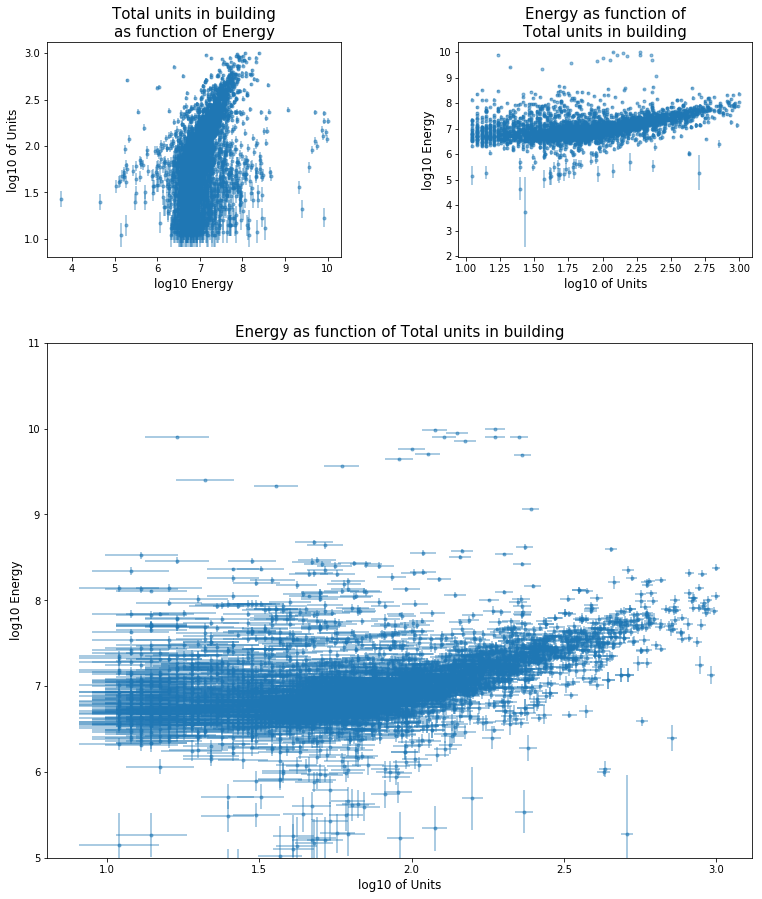

In [47]:
#I could also include errors for number of units
fig2 = plt.figure(figsize=(20,15))

gs1 = gridspec.GridSpec(3, 3, fig2)
#gs1.update(left=0.68, right=0.68, wspace=.2)
fig2.subplots_adjust(hspace=0.4, wspace=0.4)


ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
ax1.errorbar(np.log10(limited_bblnrgdata.nrg), np.log10(limited_bblnrgdata.UnitsTotal), 
            yerr=limited_bblnrgdata.errorsunits, fmt='.',
            alpha=0.5)
ax1.set_ylabel("log10 of Units", fontsize=12)
ax1.set_xlabel("log10 Energy", fontsize=12)
#pl.suptitle
ax1.set_title("Total units in building\nas function of Energy", fontsize=15)


ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=1)
ax2.errorbar(np.log10(limited_bblnrgdata.UnitsTotal), np.log10(limited_bblnrgdata.nrg), 
            yerr=limited_bblnrgdata.errorsnrg, fmt='.',
            alpha=0.5)
ax2.set_xlabel("log10 of Units", fontsize=12)
ax2.set_ylabel("log10 Energy", fontsize=12)
ax2.set_title("Energy as function of\nTotal units in building", fontsize=15)

ax4 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
ax4.errorbar(np.log10(limited_bblnrgdata.UnitsTotal), np.log10(limited_bblnrgdata.nrg), 
            yerr=limited_bblnrgdata.errorsnrg,
           xerr=limited_bblnrgdata.errorsunits, alpha=0.5, fmt='.')
ax4.set_xlabel("log10 of Units", fontsize=12)
ax4.set_ylabel("log10 Energy", fontsize=12)
ax4.set_title("Energy as function of Total units in building", fontsize=15)
ax4.set_ylim(5,11)

print ("The largest error bar is for")
limited_bblnrgdata[limited_bblnrgdata.errorsnrg == limited_bblnrgdata.errorsnrg.max()]


#### Figure 9: The same as Figure 5 and 6, but with errorbars. In the top panel: the left plot has the errors on the Units in the building plotted, while the right panel has the errors on the energy plotted. They are too small to see. The bottom panel is a zoom-in of the upper right plot. Errors are measured by assuming Poisson statistics at the measurement level for energy per square foot, area, and for the number of units, and propagate properly to the log space. Notice that we do not know what the units of energy really represent: the Poisson statitics should be applied to the measured counts, but the enrgy consumption is a continuous variable, only discretized by the act of measuring it. 


### Calculating the degrees of freedom of this model

In [48]:
ols_model_fit_3.params, ols_model_fit_4.params, len(ols_model_fit_3.params), len(ols_model_fit_4.params),\
len(limited_bblnrgdata), len(limited_bblnrgdata['UnitsTotal']), len(limited_bblnrgdata['nrg'])

(Intercept   -3.672768
 lognrg2     -0.057467
 lognrg       1.197009
 dtype: float64, Intercept    7.982471
 logunits2    0.527353
 logunits    -1.545153
 dtype: float64, 3, 3, 4253, 4253, 4253)

In [49]:
#degrees of freedom: number of observations - number of model parameters
# note: these are reported as dof of the residuals in the statsmodels fit summary, but jsut to make sure let's calculate them
dof = len(limited_bblnrgdata) - len(ols_model_fit_3.params) 
print ("degrees of freedom:" , dof)

degrees of freedom: 4250


## Adding the errors and calculating the chi square

In [50]:
## using predefined function of chi squared above

print ("Units vs Energy residuals (no errors include): %.2f"%\
       (chi2(np.log10(limited_bblnrgdata.UnitsTotal), ols_model_fit_3.predict()) / 
        float(dof)))

print ("Units vs Energy chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(limited_bblnrgdata.UnitsTotal), ols_model_fit_3.predict(), 
            errors = limited_bblnrgdata.errorsnrg) / dof))

print ("Units vs Energy chi square per DOF : %.2f"%\
       (chi2(np.log10(limited_bblnrgdata.UnitsTotal), ols_model_fit_3.predict(), 
            errors = np.sqrt(limited_bblnrgdata.errorsnrg**2 + 
                             limited_bblnrgdata.errorsunits**2))  / dof))


Units vs Energy residuals (no errors include): 0.06
Units vs Energy chi square per DOF w independent variable error only: 55.45
Units vs Energy chi square per DOF : 12.73


In [51]:
print ("Energy vs Units residuals (no errors include): %.2f"%\
       (chi2(np.log10(limited_bblnrgdata.nrg), ols_model_fit_4.predict()) / dof))

print ("Energy vs Units chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(limited_bblnrgdata.nrg), ols_model_fit_4.predict(), 
            errors = limited_bblnrgdata.errorsnrg) / dof))

print ("Energy vs Units chi square per DOF : %.2f"%\
       (chi2(np.log10(limited_bblnrgdata.nrg), ols_model_fit_4.predict(), 
            errors = np.sqrt(limited_bblnrgdata.errorsnrg**2 + 
                             limited_bblnrgdata.errorsunits**2))  / dof))


Energy vs Units residuals (no errors include): 0.15
Energy vs Units chi square per DOF w independent variable error only: 4338.99
Energy vs Units chi square per DOF : 36.93


![alt text](images/chisq.gif)

## Comparing the models using the  chi square:
#### When computing a chi square statistic we are tryinf to measure the goodness of fit of a model. In other words, how close are the observed values to those which we would expect under the fitted model. Therefore, if the computed test statistic is large, then the observed and expected values are not close and the model is a poor fit to the data. The test evaluates the null hypothesis that the data are governed by the assumed distribution. Here we calculated the χ2 /DOF (reduced χ2  or χ2  per degree of freedom).The statistics follows a χ2 distribution with mean 1. In both cases considering the error enhances the test statistic. However what is surprising is that the test statistic in the case of units vs energy is smaller than that in the case of energy versus units. 

## Influence plot

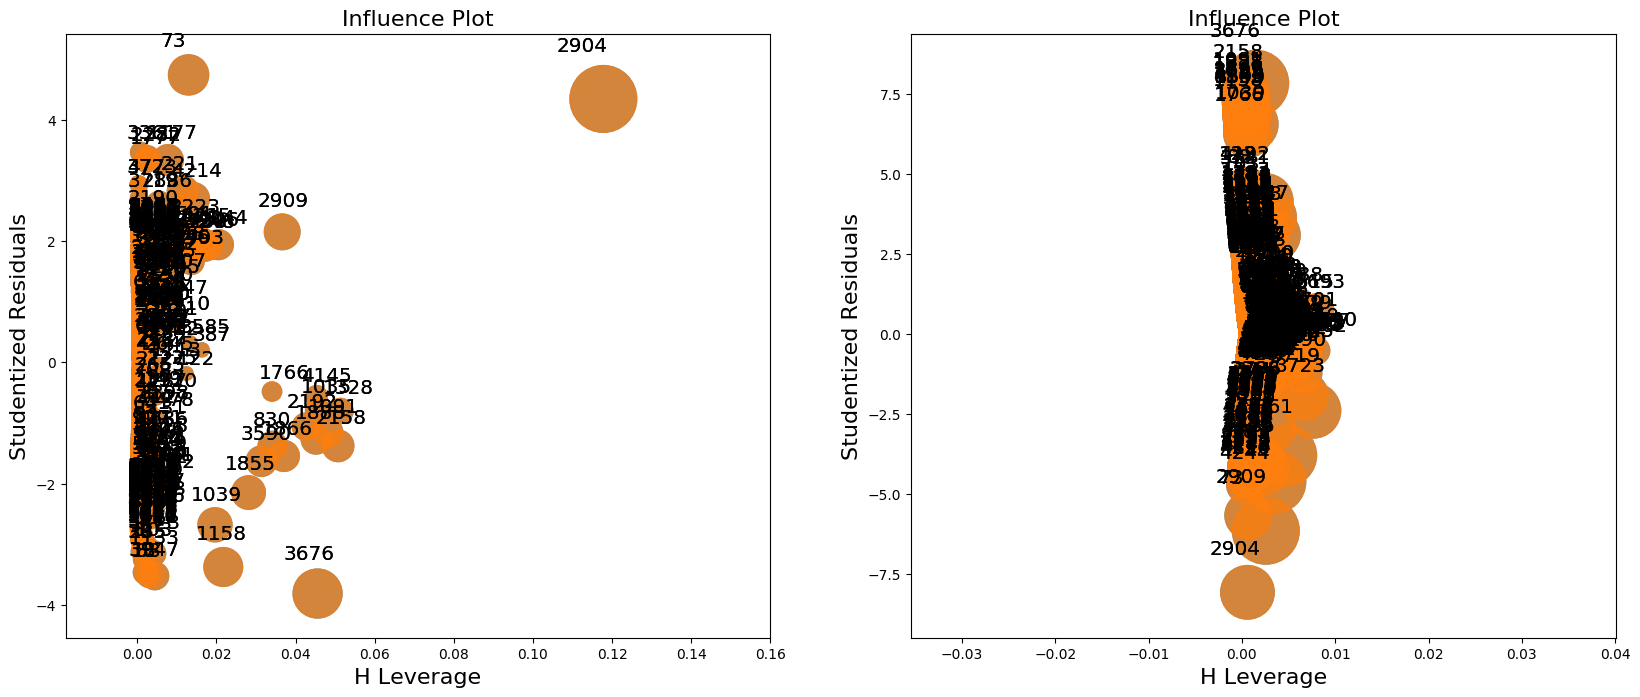

In [54]:
sm.graphics.influence_plot(ols_model_fit_3, alpha=0.05, criterion='cooks', ax=ax[0])
sm.graphics.influence_plot(ols_model_fit_4, alpha=0.05, criterion='cooks', ax=ax[1])


#### Figure 10: A plot of residuals as a function of leverage for units verses energy (left) and energy versus units (right) identifies influential observations that are not modeled well by the regression model. The quantities shown are for the the fit results of the ols model. the criterion is set to 'cooks', and the size of the points represents cooks distance. In the case of units versus energy we see that there are a lot of outliers in the data that would have an effect on the model fit and hence explain the results obtained for chi square statistics. The 2904 observation for example stands out with high residuals, high leverage, and a large cook's distance. In the scatter plot of the units vs energy most values of the exogenous variable (energy in this case) are clustered in a small range, while the endogenous variable varies greatly for those points. So the core of the distribution has low predictive power, however the presence of "outliers" with high and low energy values has enhanced in the fit.

# Comparing the linear and curve fit with Likelihood Ratio LR test 
significance $\alpha=0.05$

In [53]:
# energy vs units
lr_stat, p_value, df_diff  = ols_model_fit_4.compare_lr_test(ols_model_fit_2)
print('likelihood ratio test statistic = {}\np-value = {}\n\
difference in df between models = {}'.format(lr_stat, p_value, df_diff))

likelihood ratio test statistic = 309.0248491097318
p-value = 3.5616874952967073e-69
difference in df between models = 1.0


#### According to wilk's theorum: Assuming the likelihood ratio test statistic is chi-sq distributed we use the above table. Using the chi square table at significance level 0.05 and one degrees of freedom the chi-square critical value given by the table is (3.841). The statistic we computed (309.03) is bigger than chi-squared critical value.  We also got a very low p-value almost zero which is less than our significance level 0.05.Therefore we reject the null hypothesis that the nested model is better. Concluding that the complex model better explains the data.